<a href="https://colab.research.google.com/github/BallAd15/PaperImplementations/blob/main/Paper_Implementation_QoS_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper Implementation - QoS-Aware Web Service Recommendation by Collaborative Filtering

https://ieeexplore.ieee.org/document/5674010

Zibin Zheng, Student Member, IEEE, Hao Ma, Michael R. Lyu, Fellow, IEEE, and
Irwin King, Senior Member, IEEE

## 1. Getting the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Datasets/QoS"

readme.txt  rtMatrix.txt  tpMatrix.txt	userlist.txt  wslist.txt


* userlist.txt  - information of **339 service users**. Format: | User ID | IP Address | Country | Continent | AS | Latitude | Longitude | Region | City |
* wslist.txt  - information of the **5,825 Web services**. Format: | Service ID |WSDL Address | Service Provider | IP Address | Country | Continent | AS | Latitude | Longitude | Region | City |
* rtMatrix.txt  - **339 * 5825** user-item matrix of response-time.
* tpMatrix.txt  - **339 * 5825**  user-item matrix for throughput.
* readme.txt    - descriptions of the dataset.

In [3]:
import pandas as pd

pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Display full width

folderPath = "/content/drive/My Drive/Datasets/QoS"
userColumns = ['User ID', 'IP Address', 'Country', 'IP No.', 'AS', 'Latitude', 'Longitude']
wsColumns = ['Service ID',	'WSDL Address',	'Service Provider',	'IP Address',	'Country',	'IP No.',	'AS',	'Latitude',	'Longitude']

# Load the text file into a pandas DataFrame
userData = pd.read_csv(f'{folderPath}/userlist.txt', sep='\t', skiprows=2, names=userColumns)
wsData = pd.read_csv(f'{folderPath}/wslist.txt', sep='\t', skiprows=2, names=wsColumns, encoding='latin1')
rtMatrix = pd.read_csv(f'{folderPath}/rtMatrix.txt', sep='\t')
tpMatrix = pd.read_csv(f'{folderPath}/tpMatrix.txt', sep='\t')

print(userData.head())

   User ID      IP Address        Country      IP No.                                     AS  \
0        0  12.108.127.138  United States   208437130             AS7018 AT&T Services, Inc.   
1        1    12.46.129.15  United States   204374287             AS7018 AT&T Services, Inc.   
2        2    122.1.115.91          Japan  2046915419  AS4713 NTT Communications Corporation   
3        3    128.10.19.52  United States  2148143924                 AS17 Purdue University   
4        4    128.10.19.53  United States  2148143925                 AS17 Purdue University   

   Latitude  Longitude  
0   38.0000   -97.0000  
1   38.0464  -122.2300  
2   35.6850   139.7514  
3   40.4249   -86.9162  
4   40.4249   -86.9162  


In [4]:
print(wsData.head())

   Service ID                                       WSDL Address Service Provider    IP Address  \
0           0  http://ewave.no-ip.com/ECallws/CinemaData.asmx...        no-ip.com  8.23.224.110   
1           1  http://ewave.no-ip.com/ECallws/StadiumSinchron...        no-ip.com  8.23.224.110   
2           2  http://ewave.no-ip.com/EcallWS/CinemaSinchroni...        no-ip.com  8.23.224.110   
3           3  http://ewave.no-ip.com/ECallws/StadiumData.asm...        no-ip.com  8.23.224.110   
4           4  http://ewave.no-ip.com/ECallws/BuyerData.asmx?...        no-ip.com  8.23.224.110   

         Country     IP No.                              AS  Latitude  Longitude  
0  United States  135782510   AS3356 Level 3 Communications      38.0      -97.0  
1  United States  135782510   AS3356 Level 3 Communications      38.0      -97.0  
2  United States  135782510   AS3356 Level 3 Communications      38.0      -97.0  
3  United States  135782510   AS3356 Level 3 Communications      38.0    

In [5]:
rtMatrix.shape, tpMatrix.shape, userData.shape, wsData.shape

((338, 5826), (338, 5826), (339, 7), (5825, 9))

## 2. Data Preparation

### Normalization

In [6]:
import numpy as np

# Normalize the data
# Using min-max normalization

def min_max_normalize(matrix):
    min_vals = np.array(matrix.min(axis=1))
    max_vals = np.array(matrix.max(axis=1))
    normalized_matrix = (matrix - min_vals[:, np.newaxis]) / (max_vals - min_vals)[:, np.newaxis]
    return normalized_matrix

# Normalize rtMatrix
rtMatrix_normalized = min_max_normalize(rtMatrix)

# Normalize tpMatrix
tpMatrix_normalized = min_max_normalize(tpMatrix)

In [7]:
rtMatrix.head()

5.982  0.228  0.237  0.221  0.222  0.527  0.453  0.566  0.386  0.649  5.394   5.55  7.067  \
0  2.130  0.262  0.273  0.251  0.254  0.427  0.652  0.642  0.439  0.720  0.425  0.581  1.950   
1  0.854  0.366  0.376  0.357  0.358  0.115  0.649  0.980  0.642  1.213  0.664  0.925  2.271   
2  0.693  0.226  0.233  0.220  0.219  0.344  0.765  0.793  0.371  0.552  0.397  0.545  4.602   
3  0.866  0.227  0.233  0.220  0.221  0.366  0.836  0.863  0.372  0.619  0.356  0.538  4.443   
4  1.833  0.251  0.257  0.261  0.239  0.254  0.896  0.920  0.421  0.860  0.380  0.577  3.291   

   6.415  5.828  5.875  5.782  5.776  5.565  0.239   0.24  6.016  0.247  0.247.1  5.611   0.25  \
0  1.363  0.708  0.821  0.859  0.740  0.369  0.197  0.183  0.741  0.173    0.173  0.350  0.172   
1  2.226  3.278  1.289  1.363  1.271  0.424  0.218  0.212  1.484  0.215    0.218  0.417  0.204   
2  0.552  0.513  0.771  0.759  0.960  0.528  0.232  0.232  0.912  0.233    0.231  0.604  0.222   
3  1.279  1.913  0.386  0.681  0.887  0.472  0.232  0.232  0.444  0.223    0.224  0.626  0.220   
4  0.591 -1.000  0.405  0.993  0.739  0.555  0.231  0.172  0.362  0.177    0.178  0.370  0.180   

   0.249  0.249.1  6.215  0.328  0.329   5.93   0.43  0.426  8.137  0.299  5.835  0.982  5.842  \
0  0.171    0.170  0.717  0.258  0.244  1.329  0.344  0.319  7.657  1.428  0.573  0.615  0.524   
1  0.205    0.204  2.912  0.206  0.211  0.579  0.230  0.227  3.150  0.289  0.730  0.502  3.564   
2  0.223    0.223  0.868  0.307  0.304  0.578  0.286  0.287  1.792  0.267  0.713  0.790  0.685   
3  0.222    0.227  0.846  0.292  0.293  0.903  0.283  0.287  1.529  0.269  0.708  0.839  0.676   
4  0.179    0.180  0.475  0.244  0.243  0.682  0.336  0.309  1.425  0.226  0.375  0.697  0.551   

   5.809  6.969  0.696  8.561  5.763  5.759  0.266  0.268  0.279  5.955  0.292  0.327  0.433  \
0  0.554  1.569  3.833  0.554  0.516  0.996  0.208  0.200  0.204  0.704  0.394  0.215  0.185   
1  0.784  0.655  0.641  0.644  0.490  0.798  0.265  0.261  0.266  0.556  0.128  0.130  0.130   
2  0.694  1.065  0.950  2.159  0.695  0.757  0.244  0.252  0.259  0.898  0.268  0.276  0.238   
3  0.645  1.070  0.867  3.331  0.447  0.510  0.250  0.241  0.270  0.524  0.284  0.229  0.228   
4  0.372  0.529  4.544  4.001  0.392  0.378  0.238  0.197  0.202  0.385  0.184  0.249  0.234   

   1.535  5.587  5.704  0.236  5.568  0.259    5.8  1.462  1.576  5.799    0.8  5.789  0.518  \
0  0.747  0.379  0.479  0.176  0.370  0.180  0.421  0.195  1.034  2.562  0.556  0.541  0.424   
1  0.803  0.436  0.779  0.298  0.588  0.286  0.453  0.223  1.322  0.850  0.923  0.598  0.314   
2  1.143  0.552  0.660  0.232  0.489  0.236  0.474  0.241  1.334  0.539  0.752  0.762  0.473   
3  0.959  0.578  0.625  0.233  0.487  0.236  0.481  0.243  1.332  0.536  0.744  0.764  0.479   
4  0.725  0.409  0.412  0.178  0.374  0.180  0.372  0.189  1.074  0.360  0.399  0.365  0.365   

    0.82   2.267  1.713  0.611  1.264  0.687  0.566.1      -1  6.157   5.72   5.84  1.025   5.82  \
0  0.485   5.434  1.626  0.579  0.983  0.459    0.324   0.540  0.816  0.724  0.567  0.880  0.501   
1  0.523   1.841  3.368  0.578  0.970  0.479    0.567   9.285  0.854  1.120  0.459  1.198  0.410   
2  0.666   3.714  1.230  0.611  3.085  0.565    0.468   0.470  0.756  0.513  0.428  0.532  0.687   
3  0.659   2.868  1.816  0.710  1.066  0.553    0.466   0.697  1.008  0.508  0.657  0.962  0.684   
4  0.330  18.216  0.773  0.572  0.900  0.467    0.349  14.712  0.502  0.425  0.338  0.411  0.514   

   0.563  0.799   6.15  5.944  6.052  5.885  0.799.1  5.289  0.996  0.164  0.124  0.121  0.339  \
0  0.365  0.515  0.870  0.657  0.797  0.499    0.583  0.317  1.204  0.182  0.180  0.178  0.370   
1  0.579  0.678  0.776  0.573  1.122  0.461    0.811  0.725  1.902  0.324  0.320  0.319  0.667   
2  0.484  0.450  0.966  0.424  0.801  0.745    0.874  0.208  0.686  0.146  0.140  0.140  0.306   
3  0.482  0.880  0.971  0.866  0.966  0.755    0.878  0.208  0.686  0.157  0.145  0.149  0.308   
4  

In [8]:
rtMatrix_normalized.head()

5.982     0.228     0.237     0.221     0.222     0.527     0.453     0.566     0.386  \
0  0.150351  0.060621  0.061149  0.060092  0.060236  0.068546  0.079354  0.078874  0.069123   
1  0.092414  0.068089  0.068587  0.067640  0.067690  0.055578  0.082195  0.098694  0.081846   
2  0.080738  0.058467  0.058801  0.058181  0.058133  0.064095  0.084172  0.085507  0.065382   
3  0.093868  0.061723  0.062025  0.061371  0.061422  0.068716  0.092359  0.093717  0.069018   
4  0.137859  0.060876  0.061168  0.061363  0.060292  0.061022  0.092263  0.093431  0.069148   

      0.649     5.394      5.55     7.067     6.415     5.828     5.875     5.782     5.776  \
0  0.082621  0.068450  0.075944  0.141704  0.113508  0.082044  0.087472  0.089298  0.083582   
1  0.110308  0.082943  0.095953  0.163045  0.160802  0.213239  0.114096  0.117785  0.113199   
2  0.074014  0.066622  0.073680  0.267156  0.074014  0.072154  0.084458  0.083886  0.093471   
3  0.081443  0.068213  0.077368  0.273807  0.114644  0.146537  0.069722  0.084562  0.094924   
4  0.090511  0.067153  0.076740  0.208808  0.077421  0.000000  0.068370  0.096983  0.084623   

      5.565     0.239      0.24     6.016     0.247   0.247.1     5.611      0.25     0.249  \
0  0.065760  0.057498  0.056826  0.083630  0.056345  0.056345  0.064848  0.056297  0.056249   
1  0.070980  0.060712  0.060413  0.123816  0.060562  0.060712  0.070631  0.060014  0.060064   
2  0.072869  0.058753  0.058753  0.091182  0.058801  0.058706  0.076494  0.058277  0.058324   
3  0.074048  0.061975  0.061975  0.072639  0.061522  0.061573  0.081795  0.061371  0.061472   
4  0.075669  0.059903  0.057032  0.066277  0.057275  0.057324  0.066667  0.057421  0.057372   

    0.249.1     6.215     0.328     0.329      5.93      0.43     0.426     8.137     0.299  \
0  0.056201  0.082477  0.060428  0.059756  0.111874  0.064560  0.063359  0.415842  0.116630   
1  0.060014  0.194996  0.060114  0.060363  0.078706  0.061310  0.061160  0.206859  0.064251   
2  0.058324  0.089084  0.062330  0.062187  0.075254  0.061329  0.061376  0.133149  0.060423   
3  0.061723  0.092862  0.064993  0.065044  0.095729  0.064540  0.064742  0.127220  0.063836   
4  0.057421  0.071776  0.060535  0.060487  0.081849  0.065012  0.063698  0.118005  0.059659   

      5.835     0.982     5.842     5.809     6.969     0.696     8.561     5.763     5.759  \
0  0.075560  0.077577  0.073206  0.074647  0.123403  0.232155  0.074647  0.072822  0.095879   
1  0.086233  0.074868  0.227495  0.088924  0.082494  0.081796  0.081946  0.074270  0.089622   
2  0.081692  0.085364  0.080357  0.080786  0.098479  0.092994  0.150651  0.080834  0.083790   
3  0.085920  0.092510  0.084310  0.082751  0.104130  0.093918  0.217868  0.072790  0.075960   
4  0.066910  0.082579  0.075474  0.066764  0.074404  0.269781  0.243358  0.067737  0.067056   

      0.266     0.268     0.279     5.955     0.292     0.327     0.433     1.535     5.587  \
0  0.058027  0.057642  0.057835  0.081852  0.066961  0.058363  0.056922  0.083918  0.066241   
1  0.063055  0.062855  0.063104  0.077560  0.056226  0.056325  0.056325  0.089871  0.071578   
2  0.059326  0.059707  0.060041  0.090515  0.060470  0.060852  0.059040  0.102198  0.074014   
3  0.062880  0.062428  0.063887  0.076664  0.064591  0.061824  0.061774  0.098546  0.079380   
4  0.060243  0.058248  0.058491  0.067397  0.057616  0.060779  0.060049  0.083942  0.068564   

      5.704     0.236     5.568     0.259       5.8     1.462     1.576     5.799       0.8  \
0  0.071044  0.056490  0.065808  0.056682  0.068258  0.057402  0.097704  0.171102  0.074743   
1  0.088675  0.064699  0.079155  0.064101  0.072425  0.060961  0.115741  0.092214  0.095853   
2  0.079164  0.058753  0.071010  0.058944  0.070294  0.059183  0.111307  0.073394  0.083552   
3  0.081745  0.062025  0.074803  0.062176  0.074501  0.062528  0.117310  0.077267  0.087731   
4  0.068710  0.057324  0.066861  0.057421  0.066764  0.057859  0.100925  0.066180  0.068078   

      5.7

### Combining Matrices of QoS values

In [9]:
import numpy as np

# Assuming tpMatrix and rtMatrix have the same shape
combined_matrix = np.zeros((tpMatrix_normalized.shape[0], tpMatrix_normalized.shape[1], 2))

# Fill the combined matrix with TP and RT values
combined_matrix[:,:,0] = tpMatrix_normalized.values
combined_matrix[:,:,1] = rtMatrix_normalized.values

In [10]:
combined_matrix.shape

(338, 5826, 2)

### Removing NaN values

In [11]:
combined_matrix = np.nan_to_num(combined_matrix, nan=0)

In [12]:
combined_matrix[0]

array([[0.00194472, 0.15035066],
       [0.0163234 , 0.06062062],
       [0.02305766, 0.06114901],
       ...,
       [0.01680606, 0.06023633],
       [0.0162652 , 0.06066865],
       [0.        , 0.        ]])

### i. Average QoS of web services for each user

In [13]:
# average QoS values of different Web services observed by a service user
def avg_qos_values_user(user_index):
    # Change this user_index according to the user you want to compute for

    # Extract QoS values for the specified user
    user_qos_values = combined_matrix[user_index, :, :]

    # Compute the average QoS values for the specified user
    average_qos_values = np.mean(user_qos_values, axis=0)

    return average_qos_values

In [14]:
ra = avg_qos_values_user(0) # average QoS values of different Web services observed by service user 0
ru = avg_qos_values_user(1) # average QoS values of different Web services observed by service user 1

ru[0]

0.030043834984102843

### ii. Average QoS of a web service observed by different users

In [15]:
# average QoS values of the Web service item i observed by different service users
def avg_qos_values_item(service_index):
    # Change this index according to the service you want to compute for

    service_qos_values = combined_matrix[:, service_index, :] # Extract QoS values for the specified service

    average_qos_values = np.mean(service_qos_values, axis=0) # Compute the average QoS values for the specified service

    return average_qos_values

In [16]:
ri = avg_qos_values_item(0);

ri

array([0.00253828, 0.14887212])

### iii. QoS values of web service i observed by user a

In [17]:
# QoS values of Web service item i observed by service user a
def qos_item_user(a,i):
    return combined_matrix[a, i, :]

In [18]:
qos_item_user(0,0)

array([0.00194472, 0.15035066])

## 3. Similarity Computation

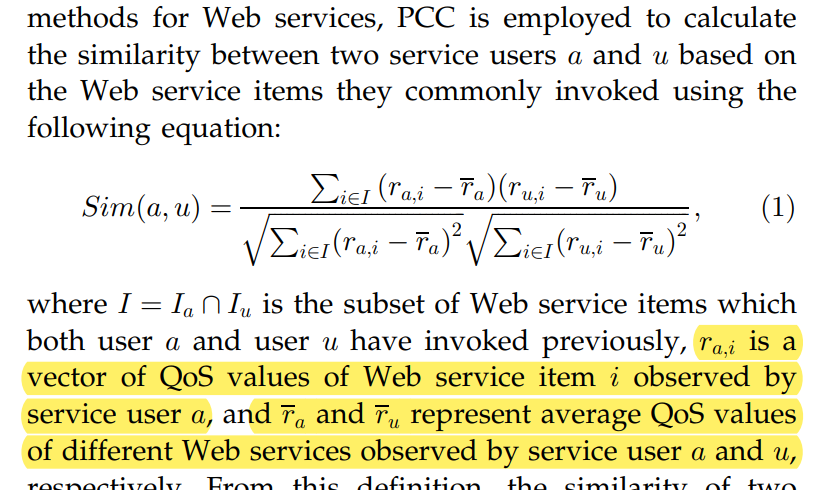

### Similarity between any two users

In [19]:
# Similarity between any two users
def userBased(a, u):
    ra = avg_qos_values_user(a)
    ru = avg_qos_values_user(u)

    numerator = 0
    denominator1 = 0
    denominator2 = 0
    # for each item
    for i in range(5826):
        #numerator += (qos_item_user(a,i) - ra)*(qos_item_user(u,i) - ru)
        #denominator1 += (qos_item_user(a,i)-ra)**2
        #denominator2 += (qos_item_user(u,i)-ru)**2
        numerator += (qos_item_user(a,i)[0] - ra[0])*(qos_item_user(u,i)[0] - ru[0]) + (qos_item_user(a,i)[1] - ra[1])*(qos_item_user(u,i)[1] - ru[1])
        denominator1 += (qos_item_user(a,i)[0]-ra[0])**2 + (qos_item_user(a,i)[1]-ra[1])**2
        denominator2 += (qos_item_user(u,i)[0]-ru[0])**2 + (qos_item_user(u,i)[1]-ru[1])**2
    denominator1 = denominator1**0.5
    denominator2 = denominator2**0.5

    similarity = numerator / (denominator1 * denominator2)

    return similarity

In [20]:
userBased(0,1), userBased(0,0)

(0.43143615193170975, 0.9999999999999999)

In [21]:
def userBasedV2(a,u):
    ra = avg_qos_values_user(a)
    ru = avg_qos_values_user(u)

    # Extract QoS values for users a and u
    qos_a = combined_matrix[a, :, :]
    qos_u = combined_matrix[u, :, :]

    # Compute numerator
    numerator = np.sum((qos_a - ra) * (qos_u - ru), axis=0)

    # Compute denominators
    denominator1 = np.sqrt(np.sum((qos_a - ra) ** 2, axis=0))
    denominator2 = np.sqrt(np.sum((qos_u - ru) ** 2, axis=0))

    # Compute similarity for each QoS value
    similarity = numerator / (denominator1 * denominator2)

    # Compute overall similarity (e.g., taking the mean)
    overall_similarity = np.mean(similarity)

    return overall_similarity

In [22]:
userBasedV2(0,1), userBasedV2(0,0)

(0.46757406977645155, 1.0)

### Similarity between any two services

In [23]:
# Similarity between any two web services
def itemBased(i, j):
    ri = avg_qos_values_item(i)
    rj = avg_qos_values_item(j)

    numerator = 0
    denominator1 = 0
    denominator2 = 0
    # for each item
    for u in range(338):
        #numerator += (qos_item_user(u,i) - ri)*(qos_item_user(u,j) - rj)
        #denominator1 += (qos_item_user(u,i)-ri)**2
        #denominator2 += (qos_item_user(u,j)-rj)**2
        numerator += ((qos_item_user(u,i)[0] - ri[0])*(qos_item_user(u,j)[0] - rj[0]) +  (qos_item_user(u,i)[1] - ri[1])*(qos_item_user(u,j)[1] - rj[1]) )
        denominator1 += (qos_item_user(u,i)[0]-ri[0])**2 + (qos_item_user(u,i)[1]-ri[1])**2
        denominator2 += (qos_item_user(u,j)[0]-rj[0])**2 + (qos_item_user(u,j)[1]-rj[1])**2
    denominator1 = denominator1**0.5
    denominator2 = denominator2**0.5

    similarity = numerator/(denominator1*denominator2)

    return similarity

In [24]:
itemBased(0,1)

0.15372765325850116

In [25]:
def itemBasedV2(i, j):
    ri = avg_qos_values_item(i)
    rj = avg_qos_values_item(j)

    # Extract QoS values for items i and j
    qos_i = combined_matrix[:, i, :]
    qos_j = combined_matrix[:, j, :]

    # Compute numerator
    numerator = np.sum((qos_i - ri) * (qos_j - rj), axis=0)

    # Compute denominators
    denominator1 = np.sqrt(np.sum((qos_i - ri) ** 2, axis=0))
    denominator2 = np.sqrt(np.sum((qos_j - rj) ** 2, axis=0))

    # Compute similarity for each QoS value
    similarity = numerator / (denominator1 * denominator2)

    # Compute overall similarity (e.g., taking the mean)
    overall_similarity = np.mean(similarity)

    return overall_similarity

In [26]:
itemBasedV2(10,100)

0.0830004692157969

### Creating the User-User Matrix

In [27]:
def user_user_similarity(dim):
    # Initialize user-user similarity matrix
    user_user_similarity_matrix = np.zeros((dim, dim))

    # Iterate through all pairs of users and compute similarity
    for i in range(dim):
        for j in range(i,dim):
            similarity = userBasedV2(i, j)
            user_user_similarity_matrix[i, j] = similarity
            user_user_similarity_matrix[j,i] = similarity

    # Ensure diagonal elements are set to 1
    np.fill_diagonal(user_user_similarity_matrix, 1)

    # Print or use user_user_similarity_matrix as needed
    return (user_user_similarity_matrix)

In [28]:
user_user_matrix = user_user_similarity(10)

In [29]:
user_user_matrix

array([[1.        , 0.46757407, 0.55568411, 0.59079931, 0.72764491,
        0.70367028, 0.70191292, 0.50197818, 0.50192343, 0.51644294],
       [0.46757407, 1.        , 0.38947241, 0.42029686, 0.45311953,
        0.45700871, 0.43908669, 0.35764282, 0.3792495 , 0.49530691],
       [0.55568411, 0.38947241, 1.        , 0.73676389, 0.62272351,
        0.59955195, 0.63571057, 0.65721339, 0.66088396, 0.32378366],
       [0.59079931, 0.42029686, 0.73676389, 1.        , 0.64167298,
        0.67028831, 0.61215571, 0.69475679, 0.65635512, 0.30430499],
       [0.72764491, 0.45311953, 0.62272351, 0.64167298, 1.        ,
        0.78835928, 0.79205721, 0.5091578 , 0.58897413, 0.48374677],
       [0.70367028, 0.45700871, 0.59955195, 0.67028831, 0.78835928,
        1.        , 0.75292061, 0.54470174, 0.57215017, 0.45105888],
       [0.70191292, 0.43908669, 0.63571057, 0.61215571, 0.79205721,
        0.75292061, 1.        , 0.51033736, 0.52446611, 0.44288179],
       [0.50197818, 0.35764282, 0.6572133

### Creating the item-item Matrix

In [30]:
def item_item_similarity():
    # Initialize user-user similarity matrix
    item_item_similarity_matrix = np.zeros((10, 10))

    # Iterate through all pairs of users and compute similarity
    for i in range(10):
        for j in range(i,10):
            similarity = itemBased(i, j)
            item_item_similarity_matrix[i, j] = similarity
            item_item_similarity_matrix[j, i] = similarity

    # Ensure diagonal elements are set to 1
    np.fill_diagonal(item_item_similarity_matrix, 1)

    # Print or use user_user_similarity_matrix as needed
    return (item_item_similarity_matrix)

In [31]:
item_item_matrix = item_item_similarity()

In [32]:
item_item_matrix

array([[1.        , 0.15372765, 0.19603673, 0.20081865, 0.27491767,
        0.38807726, 0.36324498, 0.01988128, 0.19887453, 0.39849555],
       [0.15372765, 1.        , 0.56450406, 0.64718599, 0.61322154,
        0.0920566 , 0.12663549, 0.52278712, 0.43560844, 0.22384335],
       [0.19603673, 0.56450406, 1.        , 0.65415779, 0.64937691,
        0.13452648, 0.11621993, 0.36121962, 0.50276354, 0.3313266 ],
       [0.20081865, 0.64718599, 0.65415779, 1.        , 0.67271444,
        0.08442357, 0.14433667, 0.32725742, 0.49812382, 0.26002618],
       [0.27491767, 0.61322154, 0.64937691, 0.67271444, 1.        ,
        0.08906825, 0.14299656, 0.28792178, 0.71704948, 0.27422334],
       [0.38807726, 0.0920566 , 0.13452648, 0.08442357, 0.08906825,
        1.        , 0.63968902, 0.06532897, 0.14310601, 0.59117394],
       [0.36324498, 0.12663549, 0.11621993, 0.14433667, 0.14299656,
        0.63968902, 1.        , 0.14390997, 0.17107414, 0.68269981],
       [0.01988128, 0.52278712, 0.3612196

## 4. Similar Neighbours Selection